In [71]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Задание 1

In [72]:
df = pd.read_csv('/content/train - train.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Sales'] = df['Sales'].str.replace(',', '.').astype(float)
df.head()

,ID,Order Date,Class,Region,Sub-Category,Sales
0,646,2018-12-30,Стандарт,Урал,Appliances,37229.08
1,907,2018-12-30,Стандарт,Владивосток,Bookcases,20994.61
2,908,2018-12-30,Стандарт,Владивосток,Phones,42133.86
3,909,2018-12-30,Стандарт,Владивосток,Binders,10612.00
4,1297,2018-12-30,Стандарт,Калиниград,Binders,28781.13


### а) Какие подгруппы товаров наиболее часто покупают за все время продаж (минимум 4 группы)?

In [73]:
df['Sub-Category'].value_counts()[:4]

,count
Sub-Category,
Binders,1492
Paper,1338
Furnishings,931
Phones,876


### б) Какие подгруппы товаров наиболее часто покупают за последние два года (минимум 4 группы)?

In [74]:
df['Order Date'].min()

Timestamp('2015-01-03 00:00:00')

In [75]:
df['Order Date'].max()

Timestamp('2018-12-30 00:00:00')

In [76]:
df_filtered = df[df['Order Date'] >= '2016-12-30']
df_filtered['Sub-Category'].value_counts()[:4]

,count
Sub-Category,
Binders,907
Paper,810
Furnishings,558
Phones,511


### в) Какие подгруппы товаров наиболее часто покупают за последний год (минимум 4 группы)?

In [77]:
df_filtered = df[df['Order Date'] >= '2017-12-30']
df_filtered['Sub-Category'].value_counts()[:4]

,count
Sub-Category,
Binders,496
Paper,454
Furnishings,310
Phones,291


### **Вывод:**
Во всех заданных временных интервалах наиболее популярные подгруппы товаров остаются неизменными. Это: `Binders`, `Paper`, `Furnishings` и `Phones`.

# Задание 2

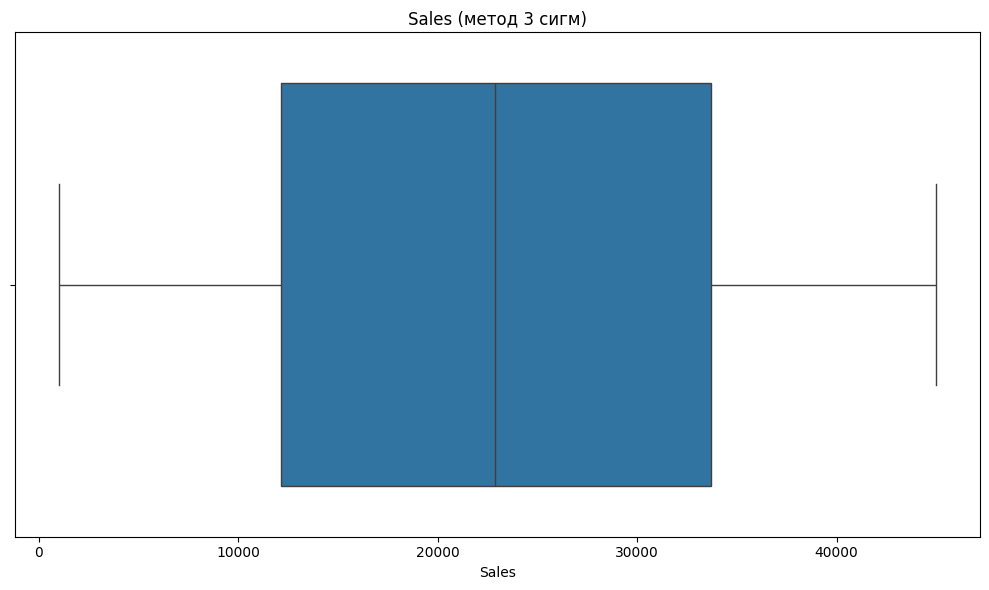

In [78]:
mean_sales = df['Sales'].mean()
std_sales = df['Sales'].std()

df_cleaned = df[(df['Sales'] >= mean_sales - 3 * std_sales) & (df['Sales'] <= mean_sales + 3 * std_sales)]

plt.figure(figsize=(10, 6))

sns.boxplot(x=df_cleaned['Sales'])
plt.title('Sales (метод 3 сигм)')

plt.tight_layout()
plt.show()

In [79]:
original_count = df.shape[0]
cleaned_count = df_cleaned.shape[0]
removed_count = original_count - cleaned_count

print(f'Общее количество строк в исходных данных: {original_count}')
print(f'Количество строк после удаления выбросов: {cleaned_count}')
print(f'Количество удаленных строк: {removed_count}')

Общее количество строк в исходных данных: 9800
Количество строк после удаления выбросов: 9800
Количество удаленных строк: 0


Метод не обнаружил аномалии, попробуем применить изоляционный лес

In [80]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.02)

yhat = iso_forest.fit_predict(df[['Sales']])

mask_outliers = yhat != 1
df_cleaned_iso = df[~mask_outliers]

removed_count_iso = df.shape[0] - df_cleaned_iso.shape[0]
print(f'Количество удаленных строк (метод Isolation Forest): {removed_count_iso}')

Количество удаленных строк (метод Isolation Forest): 195


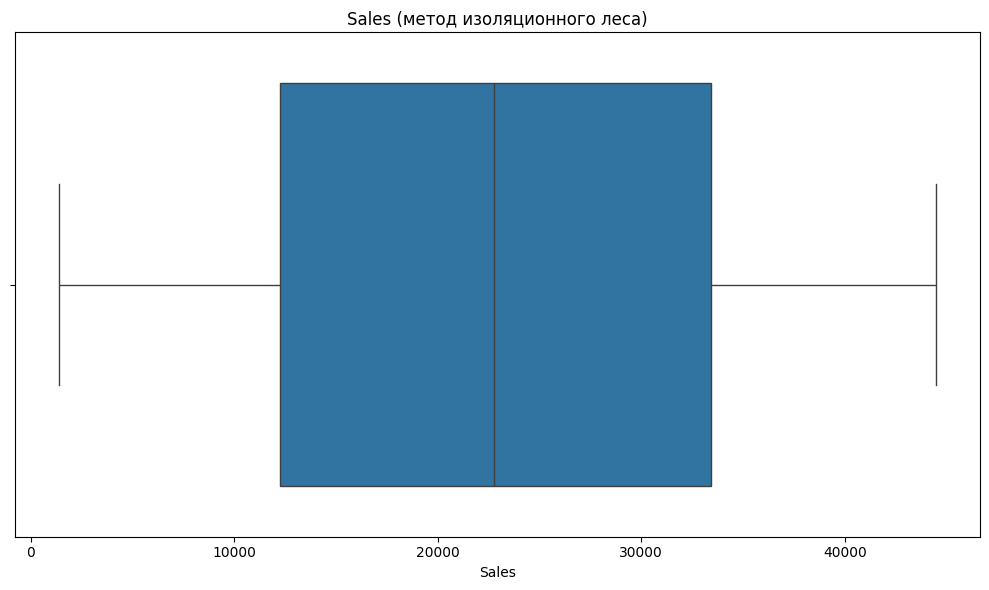

In [81]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df_cleaned_iso['Sales'])
plt.title('Sales (метод изоляционного леса)')

plt.tight_layout()
plt.show()

# Задание 3

Для этого задания необходимо разбить все покупки на энное количество групп “Sale_group” (Допустим маленькие продажи, средние и высокие) на основе Sales

Сгруппировать данные на основе региона и группы продаж (Region, Sale_group). Определить основные тенденции и паттерны. Выделить наиболее «прибыльную» группу.


In [82]:
bins = [0, df['Sales'].quantile(0.33), df['Sales'].quantile(0.67), df['Sales'].max()]
labels = ['Низкие продажи', 'Средние продажи', 'Высокие продажи']
df['Sale_group'] = pd.cut(df['Sales'], bins=bins, labels=labels, include_lowest=True)
df

,ID,Order Date,Class,Region,Sub-Category,Sales,Sale_group
0,646,2018-12-30,Стандарт,Урал,Appliances,37229.080,Высокие продажи
1,907,2018-12-30,Стандарт,Владивосток,Bookcases,20994.610,Средние продажи
2,908,2018-12-30,Стандарт,Владивосток,Phones,42133.860,Высокие продажи
3,909,2018-12-30,Стандарт,Владивосток,Binders,10612.000,Низкие продажи
4,1297,2018-12-30,Стандарт,Калиниград,Binders,28781.130,Средние продажи
...,...,...,...,...,...,...,...
9795,1760,2015-01-05,Стандарт,Владивосток,Art,8639.472,Низкие продажи
9796,740,2015-01-04,Стандарт,Урал,Labels,15246.050,Низкие продажи
9797,741,2015-01-04,Стандарт,Урал,Storage,20415.810,Средние продажи
9798,742,2015-01-04,Стандарт,Урал,Binders,4559.085,Низкие продажи


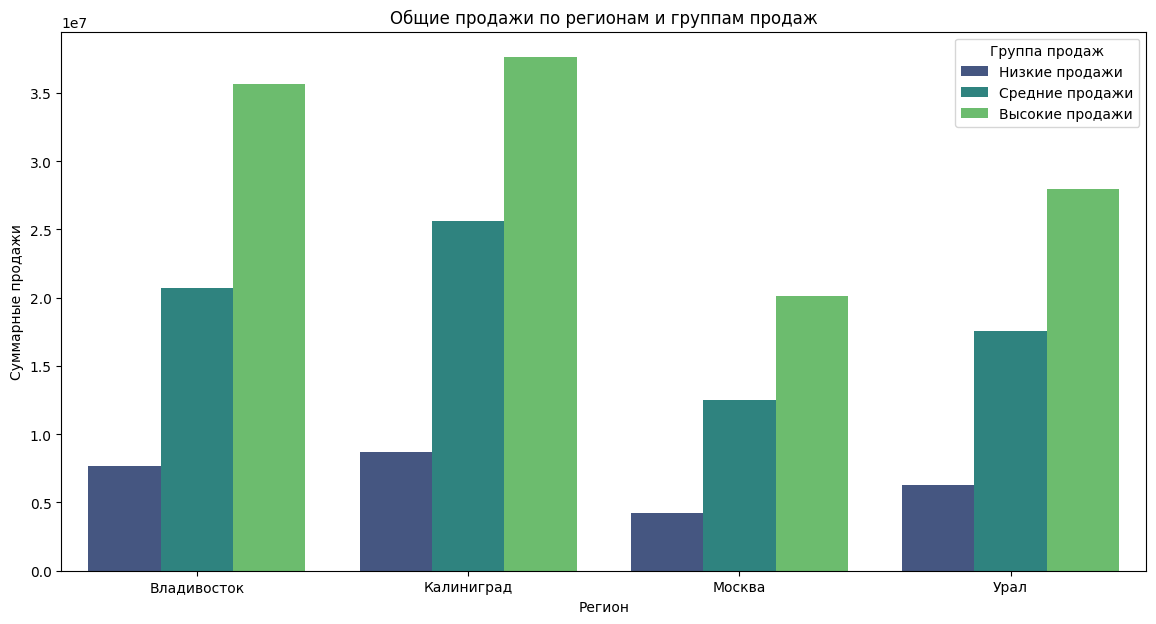

In [83]:
grouped = df.groupby(['Region', 'Sale_group']).agg(
    Total_Sales=('Sales', 'sum'),
    Count_Orders=('Sales', 'count')
).reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=grouped, x='Region', y='Total_Sales', hue='Sale_group', palette='viridis')
plt.title('Общие продажи по регионам и группам продаж')
plt.xlabel('Регион')
plt.ylabel('Суммарные продажи')
plt.legend(title='Группа продаж')
plt.show()

In [84]:
grouped['Avg_Sales_Per_Order'] = grouped['Total_Sales'] / grouped['Count_Orders']

most_profitable_group = grouped.groupby('Sale_group')['Avg_Sales_Per_Order'].mean().idxmax()

print(f'Наиболее прибыльная группа продаж: {most_profitable_group}')

Наиболее прибыльная группа продаж: Высокие продажи


In [85]:
most_profitable_region_total = df.groupby('Region')['Sales'].sum().idxmax()
most_profitable_sales_total = df.groupby('Region')['Sales'].sum().max()

print(f'Самый прибыльный регион по общим продажам: {most_profitable_region_total}')
print(f'Общие продажи в этом регионе: {most_profitable_sales_total}')

Самый прибыльный регион по общим продажам: Калиниград
Общие продажи в этом регионе: 71930299.723


In [86]:
grouped = df.groupby(['Region', 'Sale_group']).agg(
    Total_Sales=('Sales', 'sum')
).reset_index()

most_profitable_region_per_group = grouped.loc[grouped.groupby('Sale_group')['Total_Sales'].idxmax()]

print("Самый прибыльный регион по каждой категории продаж:")
print(most_profitable_region_per_group)

Самый прибыльный регион по каждой категории продаж:
       Region       Sale_group   Total_Sales
3  Калиниград   Низкие продажи  8.702214e+06
4  Калиниград  Средние продажи  2.562554e+07
5  Калиниград  Высокие продажи  3.760255e+07
